<a href="https://colab.research.google.com/github/ranctor17/ADALL.Github/blob/main/3582904N_ADALL_Porject_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
AI-Driven Analytics with Large Language Models (CDA1C03) AY 2025-2026 OCT

In [ ]:


https://www.kaggle.com/datasets/blastchar/telco-customer-churn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATASET LOADED SUCCESSFULLY FROM GOOGLE DRIVE

Dataset Shape: (7043, 21)

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges Churn
0  7590-VHVEG  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No          No              No  Month-to-month              Yes           Electronic check           29.85        29.85    No
1  5575-GNVDE    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No          No              No    

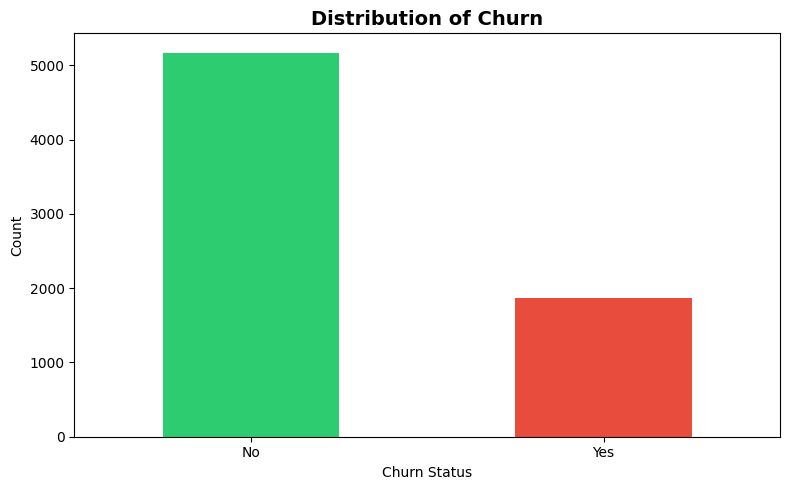


PART 3: DATA CLEANING AND PREPROCESSING

--- Cleaning TotalCharges column ---
NaN values in TotalCharges: 11

--- Data Types After Cleaning ---
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Duplicate rows: 22

Categorical columns (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMet

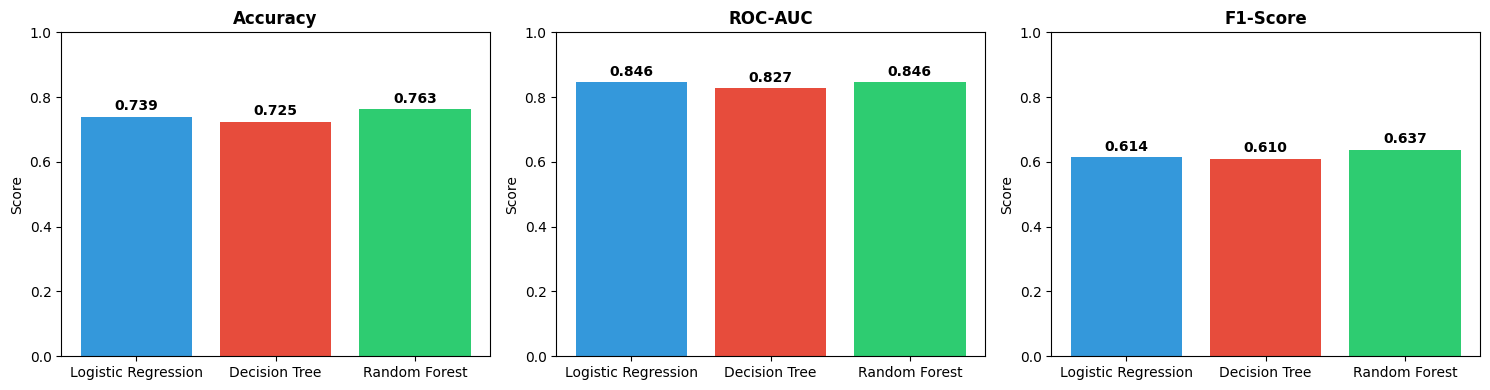


PART 12: SHAP ANALYSIS FOR MODEL INTERPRETABILITY

Generating SHAP values (this may take a moment)...
SHAP values shape: (500, 36, 2)


<Figure size 1000x800 with 0 Axes>

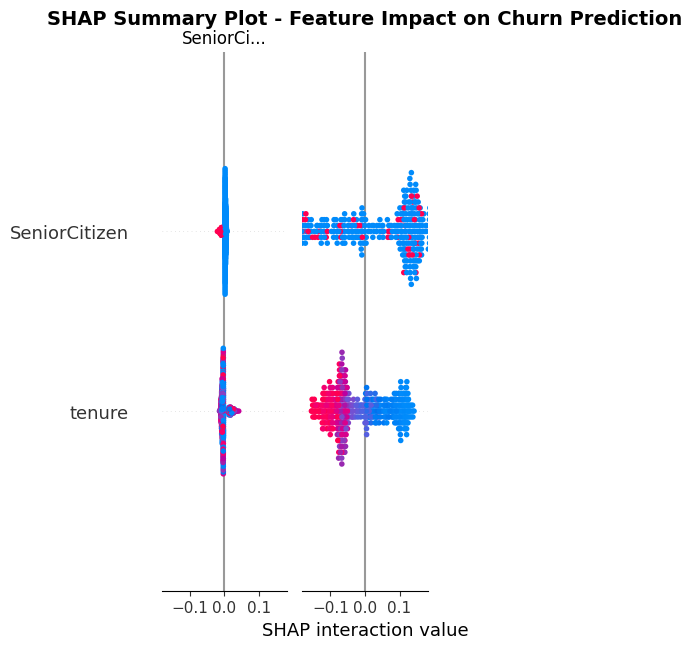

<Figure size 1000x800 with 0 Axes>

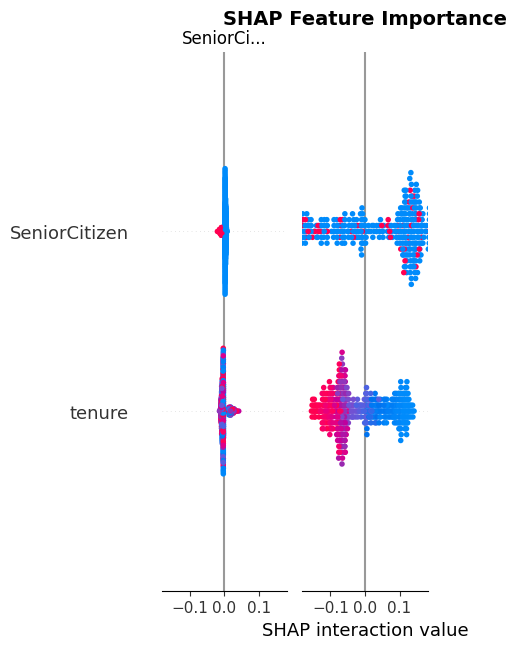


SHAP analysis completed!

PART 13: KEY INSIGHTS FOR PRESENTATION

Top 10 Features Driving Churn (SHAP):
                       feature  mean_shap
2               MonthlyCharges   0.075989
3                 TotalCharges   0.075989
26         StreamingMovies_Yes   0.058348
27           Contract_One year   0.058348
6            SeniorCitizen_log   0.033045
7                  gender_Male   0.033045
5                service_count   0.025793
4           avg_monthly_charge   0.025793
33      tenure_group_1-2 years   0.018230
32  PaymentMethod_Mailed check   0.018230

--- Business Insights ---

1. Contract Type Impact:
Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: Churn, dtype: float64

2. Internet Service Impact:
InternetService
DSL            18.959108
Fiber optic    41.892765
No              7.404980
Name: Churn, dtype: float64

3. Tenure Impact:
Average tenure for churned customers: 17.98 months
Average tenure for retained customers: 37

In [5]:
"""
Telecom Customer Churn Prediction - Complete ML Pipeline
For CDA1C03 ADALL Project
"""

# ============================================================================
# PART 1: IMPORT LIBRARIES AND LOAD DATA
# ============================================================================

'''
pandas - data manipulation (industry standard, efficient for tabular data, intuitive API)
numpy - numerical operations (foundation for scientific computing, C-optimized for speed)
matplotlib/seaborn - visualization
scikit-learn - machine learning (most comprehensive ML library, well-documented, production ready)
shap - model interpretability (state-of-the-art explainability, based on game theory (Shapley values)

'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_recall_curve, f1_score)
import shap
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Mount Google Drive (for Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Load dataset from Google Drive
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("="*80)
print("DATASET LOADED SUCCESSFULLY FROM GOOGLE DRIVE")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# ============================================================================
# PART 2: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

'''
Comprehensive overview before any manipulation.
Identify issues early (missing data, data types)
Class imbalance detected (26% churn) - informs samply strategy)

Skip EDA: blind modelling leads to poor results
Only visual EDA: numbers provide precision that visuals don't
'''

print("\n" + "="*80)
print("PART 2: DATA EXPLORATION")
print("="*80)

# 2.1 Basic Information
print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Statistical Summary ---")
print(df.describe())

# 2.2 Check for missing values
print("\n--- Missing Values ---")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# 2.3 Check target distribution
print("\n--- Target Variable Distribution ---")
print(df['Churn'].value_counts())
print(f"\nChurn Rate: {df['Churn'].value_counts(normalize=True)['Yes']:.2%}")

# 2.4 Visualize target distribution
plt.figure(figsize=(8, 5))
df['Churn'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Distribution of Churn', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PART 3: DATA CLEANING AND PREPROCESSING
# ============================================================================

'''
TotalCharge Conversion.
Problem: TotalCharges stored as string with spaces ("" "")
Solution: pd.to_numeric(...,errors='coerce') converts to float, ""becomes NaN
Result: 11NaN values found

Handling Missing TotalCharges
Filling with zero is logically correct and preserves data.
Otherwise it will:
Drop rows: Loses 11 customers, reduces dataset
Fill with mean: Misleading ($2,283 for new customers)
Fill with MonthlyCharges: Assumes 1 month, but tenure=0

Drop customerID
CustomerID is unique identifier (like primary key). Would cause overfitting  if encoded. not a feature, just a label.
'''

print("\n" + "="*80)
print("PART 3: DATA CLEANING AND PREPROCESSING")
print("="*80)

# Create a copy for processing
df_clean = df.copy()

# 3.1 Handle TotalCharges (convert to numeric and handle spaces)
print("\n--- Cleaning TotalCharges column ---")
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

# Check for NaN values created
print(f"NaN values in TotalCharges: {df_clean['TotalCharges'].isna().sum()}")

# Handle missing values in TotalCharges
# These are likely new customers (tenure = 0), so fill with 0
df_clean['TotalCharges'].fillna(0, inplace=True)

# 3.2 Drop customerID (not useful for modeling)
df_clean = df_clean.drop('customerID', axis=1)

# 3.3 Verify data types
print("\n--- Data Types After Cleaning ---")
print(df_clean.dtypes)

# 3.4 Check for duplicates
print(f"\nDuplicate rows: {df_clean.duplicated().sum()}")

# 3.5 Identify categorical and numerical columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')  # Remove target variable
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")

# ============================================================================
# PART 4: FEATURE ENGINEERING
# ============================================================================

'''
Tenure Groups (Binning).
Keep raw tenure: Model must learn threholds from scratch.
Too many bins (monthly): Overfitting, noise
Linear assumption: Misses critical early-churn period

AverageMonthlyCharge
Why Add +1 to Tenure
Problem: tenure=0 causes division by zero
Solution:tenure +1 ensures no error
Result: New customers get their MonthlyCharges as average
Capture pricing trends: Did charge increase/decrease over time?
Detect promotional periods: High total but short tenure = expensive initially.
Business insights: Customers paying $80/month average are 2x more likely to churn.

Derived feature combining two existing ones creates new signal.

Log transformation for skewness
Before: Outliers dominate
        Model biased to extremes
        Large gradients
        Hard to interpret

After:  Outliers compressed
        Even weight distribution
        Stable gradients
        Multiplicative changes

Why log1p Not log?
Handle zero: log(0) = error, log1p(0)=0
Safe: No nee to filter zeros first
Best practice for right-skewed data

Don't
Square root: Less effective for high skewness
Box-Cox: Requires positive values, more complex
ignore skewness: Linear models suffers, poor convergence.

'''

print("\n" + "="*80)
print("PART 4: FEATURE ENGINEERING")
print("="*80)

df_processed = df_clean.copy()

# 4.1 Create tenure groups (binning)
print("\n--- Creating Tenure Groups ---")
df_processed['tenure_group'] = pd.cut(df_processed['tenure'],
                                       bins=[0, 12, 24, 48, 72],
                                       labels=['0-1 year', '1-2 years', '2-4 years', '4+ years'])

# 4.2 Create average monthly charge
df_processed['avg_monthly_charge'] = df_processed['TotalCharges'] / (df_processed['tenure'] + 1)

# 4.3 Create service count (number of services subscribed)
service_cols = ['PhoneService', 'MultipleLines', 'InternetService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

df_processed['service_count'] = 0
for col in service_cols:
    df_processed['service_count'] += (df_processed[col] == 'Yes').astype(int)

print(f"Service count range: {df_processed['service_count'].min()} to {df_processed['service_count'].max()}")

# 4.4 Handle skewness in numerical features
print("\n--- Checking Skewness ---")
for col in numerical_cols:
    skewness = df_processed[col].skew()
    print(f"{col}: {skewness:.2f}")

    if abs(skewness) > 1:
        print(f"  -> Applying log transformation to {col}")
        df_processed[f'{col}_log'] = np.log1p(df_processed[col])

# ============================================================================
# PART 5: ENCODING CATEGORICAL VARIABLES
# ============================================================================

print("\n" + "="*80)
print("PART 5: ENCODING CATEGORICAL VARIABLES")
print("="*80)

# 5.1 Binary encoding for target variable
df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

# 5.2 One-hot encoding for categorical variables
print("\n--- Applying One-Hot Encoding ---")

# Create list of categorical columns to encode
categorical_to_encode = categorical_cols.copy()
if 'tenure_group' in df_processed.columns:
    categorical_to_encode.append('tenure_group')

# Apply one-hot encoding
df_encoded = pd.get_dummies(df_processed, columns=categorical_to_encode, drop_first=True)

print(f"Shape after encoding: {df_encoded.shape}")
print(f"New columns created: {df_encoded.shape[1] - df_processed.shape[1]}")

# ============================================================================
# PART 6: HANDLE CLASS IMBALANCE
# ============================================================================

print("\n" + "="*80)
print("PART 6: PREPARING TRAIN-TEST SPLIT WITH STRATIFICATION")
print("="*80)

# Separate features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass distribution (%):")
print(y.value_counts(normalize=True) * 100)

# Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

# ============================================================================
# PART 7: FEATURE SCALING
# ============================================================================

print("\n" + "="*80)
print("PART 7: FEATURE SCALING")
print("="*80)

# Identify numerical features for scaling
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nNumerical features to scale ({len(numerical_features)}): {numerical_features}")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("\nScaling completed!")

# ============================================================================
# PART 8: BASELINE MODEL - LOGISTIC REGRESSION
# ============================================================================

print("\n" + "="*80)
print("PART 8: BASELINE MODEL - LOGISTIC REGRESSION")
print("="*80)

# Train logistic regression
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n--- Logistic Regression Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_lr.head(10))

# ============================================================================
# PART 9: DECISION TREE MODEL
# ============================================================================

print("\n" + "="*80)
print("PART 9: DECISION TREE MODEL")
print("="*80)

# Train decision tree with limited depth for interpretability
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced'
)
dt_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test_scaled)
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n--- Decision Tree Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dt):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

# Feature importance
feature_importance_dt = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_dt.head(10))

# ============================================================================
# PART 10: RANDOM FOREST MODEL
# ============================================================================

print("\n" + "="*80)
print("PART 10: RANDOM FOREST MODEL")
print("="*80)

# Train random forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n--- Random Forest Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_rf.head(10))

# ============================================================================
# PART 11: MODEL COMPARISON
# ============================================================================

print("\n" + "="*80)
print("PART 11: MODEL COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_dt),
        roc_auc_score(y_test, y_pred_proba_rf)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf)
    ]
})

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['Accuracy', 'ROC-AUC', 'F1-Score']
for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df['Model'], comparison_df[metric],
                color=['#3498db', '#e74c3c', '#2ecc71'])
    axes[i].set_title(metric, fontsize=12, fontweight='bold')
    axes[i].set_ylim([0, 1])
    axes[i].set_ylabel('Score')
    for j, v in enumerate(comparison_df[metric]):
        axes[i].text(j, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PART 12: SHAP ANALYSIS (for interpretability)
# ============================================================================

print("\n" + "="*80)
print("PART 12: SHAP ANALYSIS FOR MODEL INTERPRETABILITY")
print("="*80)

# Use Random Forest for SHAP analysis (best performing model)
print("\nGenerating SHAP values (this may take a moment)...")

# Sample data for faster computation
sample_size = min(500, len(X_test_scaled))
X_test_sample = X_test_scaled.sample(n=sample_size, random_state=42)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sample)

# If binary classification, use the positive class (churn = 1)
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

print(f"SHAP values shape: {shap_values_to_plot.shape}")

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_to_plot, X_test_sample, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Churn Prediction',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP Feature Importance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_to_plot, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSHAP analysis completed!")

# ============================================================================
# PART 13: GENERATE INSIGHTS
# ============================================================================

print("\n" + "="*80)
print("PART 13: KEY INSIGHTS FOR PRESENTATION")
print("="*80)

# Top features from SHAP - Fixed version
# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values_to_plot).mean(axis=0)

# Ensure it's 1D
if mean_shap_values.ndim > 1:
    mean_shap_values = mean_shap_values.flatten()

# Get feature names as list
feature_names = X_test_sample.columns.tolist()

# Create lists explicitly
shap_importance_list = []
for i, feature in enumerate(feature_names):
    shap_importance_list.append({
        'feature': feature,
        'mean_shap': float(mean_shap_values[i])
    })

shap_importance = pd.DataFrame(shap_importance_list).sort_values('mean_shap', ascending=False)

print("\nTop 10 Features Driving Churn (SHAP):")
print(shap_importance.head(10))

# Business insights based on original data
print("\n--- Business Insights ---")
print(f"\n1. Contract Type Impact:")
print(df_clean.groupby('Contract')['Churn'].apply(lambda x: (x=='Yes').sum() / len(x) * 100))

print(f"\n2. Internet Service Impact:")
print(df_clean.groupby('InternetService')['Churn'].apply(lambda x: (x=='Yes').sum() / len(x) * 100))

print(f"\n3. Tenure Impact:")
print(f"Average tenure for churned customers: {df_clean[df_clean['Churn']=='Yes']['tenure'].mean():.2f} months")
print(f"Average tenure for retained customers: {df_clean[df_clean['Churn']=='No']['tenure'].mean():.2f} months")

print(f"\n4. Monthly Charges Impact:")
print(f"Average monthly charges for churned customers: ${df_clean[df_clean['Churn']=='Yes']['MonthlyCharges'].mean():.2f}")
print(f"Average monthly charges for retained customers: ${df_clean[df_clean['Churn']=='No']['MonthlyCharges'].mean():.2f}")

# ============================================================================
# PART 14: SAVE RESULTS
# ============================================================================

print("\n" + "="*80)
print("PART 14: SAVING RESULTS")
print("="*80)

# Save processed data
df_encoded.to_csv('processed_churn_data.csv', index=False)
print("✓ Processed data saved: processed_churn_data.csv")

# Save feature importance
feature_importance_rf.to_csv('feature_importance.csv', index=False)
print("✓ Feature importance saved: feature_importance.csv")

# Save SHAP importance
shap_importance.to_csv('shap_importance.csv', index=False)
print("✓ SHAP importance saved: shap_importance.csv")

# Save model comparison
comparison_df.to_csv('model_comparison.csv', index=False)
print("✓ Model comparison saved: model_comparison.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("1. churn_distribution.png")
print("2. model_comparison.png")
print("3. shap_summary_plot.png")
print("4. shap_feature_importance.png")
print("5. processed_churn_data.csv")
print("6. feature_importance.csv")
print("7. shap_importance.csv")
print("8. model_comparison.csv")